<a href="https://colab.research.google.com/github/Smart-Pigs/Depth-Images/blob/main/Weight_Estimation_Xception_Cropped_cleaned_aug.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Make sure you have this folder as shortcut in your drive - /content/gdrive/MyDrive/Morota-video-data/ 

In [1]:
#Mount Google Drive 
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)

Mounted at /content/gdrive


### Data Loading

In [2]:
#@markdown Select resolution of input dataset and weeks of data

Instantiate_New_Dataset = True #@param {type:"boolean"}
Refresh_Old_Dataset = False #@param {type:"boolean"}

if Instantiate_New_Dataset == True:
  !rm -rf Week*/

Resolution = "256"  #@param ['720', '512', '256']

if Refresh_Old_Dataset == False:
  if Resolution == "720":
    !cp /content/gdrive/MyDrive/Morota-video-data/DEPTH_INDIVIDUAL/CROPPED/CROPPED_WEEK1-10_720.zip .
    !unzip -qq CROPPED_WEEK1-10_720.zip -d .
    !rm -rf *WEEK*.zip

  if Resolution == "512":
    !cp /content/gdrive/MyDrive/Morota-video-data/DEPTH_INDIVIDUAL/CROPPED/CROPPED_WEEK1-10_512.zip .
    !unzip -qq CROPPED_WEEK1-10_512.zip -d .
    !rm -rf *WEEK*.zip

  if Resolution == "256":
    !cp /content/gdrive/MyDrive/Morota-video-data/DEPTH_INDIVIDUAL/CROPPED/CROPPED_WEEK1-10_256.zip .
    !unzip -qq CROPPED_WEEK1-10_256.zip -d .
    !rm -rf *WEEK*.zip

In [3]:
import pandas as pd

In [4]:
final_map = pd.read_csv("/content/gdrive/MyDrive/Morota-video-data/final_mapping.csv")

In [5]:
weeks = final_map

In [6]:
weeks

,Unnamed: 0,image_path,Date,Pig,weight,Week,pig_on_edge
0,0,Week1/20210922/20210922_3330_b/_Depth_4683.jpg,20210922,3330,15.5,1,0
1,21,Week1/20210922/20210922_3330_b/_Depth_4682.jpg,20210922,3330,15.5,1,0
2,22,Week1/20210922/20210922_3330_b/_Depth_4625.jpg,20210922,3330,15.5,1,0
3,35,Week1/20210922/20210922_3330_b/_Depth_4704.jpg,20210922,3330,15.5,1,0
4,38,Week1/20210922/20210922_3330_b/_Depth_4855.jpg,20210922,3330,15.5,1,0
...,...,...,...,...,...,...,...
36587,96209,Week10/20211119/20211119_3342/_Depth_3044.jpg,20211119,3342,56.6,10,0
36588,96210,Week10/20211119/20211119_3342/_Depth_2546.jpg,20211119,3342,56.6,10,0
36589,96214,Week10/20211119/20211119_3342/_Depth_2741.jpg,20211119,3342,56.6,10,0
36590,96217,Week10/20211119/20211119_3342/_Depth_2754.jpg,20211119,3342,56.6,10,0


In [7]:
weeks_train = weeks[weeks["Pig"] != 3384]

In [8]:
weeks_train.shape

(27292, 7)

In [9]:
weeks_test = weeks[weeks["Pig"] == 3384]

In [10]:
weeks_test.shape

(9300, 7)

In [18]:
image_paths_train = weeks_train['image_path'].values
labels_train = weeks_train['weight'].values
image_paths_test = weeks_test['image_path'].values
labels_test = weeks_test['weight'].values

In [19]:
import tensorflow as tf
import pandas as pd
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [20]:
train_dataset = tf.data.Dataset.from_tensor_slices((image_paths_train, labels_train))
test_dataset = tf.data.Dataset.from_tensor_slices((image_paths_test, labels_test))

In [21]:
IMG_SIZE = int(Resolution)
channels = 1

def preprocess_image(image_path, label):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
#----------change gray scale and rgb----------------------------
    # img = tf.image.rgb_to_grayscale(img)
    # img = tf.repeat(img, [3], axis=-1)
#-------------------------------------------------------------------
    if int(Resolution) > IMG_SIZE:
      img = tf.image.resize(img, [IMG_SIZE, IMG_SIZE])
    img = tf.cast(img, tf.float32) / 255.0
    return img, label

In [22]:
def augment_image(image):
    image = tf.image.random_flip_left_right(image)
    k = tf.random.uniform([], minval=0, maxval=4, dtype=tf.int32)
    image = tf.image.rot90(image, k=k)

    #return tf.ensure_shape(image, (256, 256, 3))
    return image

In [23]:
#---------------------for size 512, use batch size 64, if smaller, could change to 128--------------------------
batch_size = 64
#---------------------------------------------------------------------------------------------------------------------------
train_dataset = train_dataset.shuffle(len(labels_train))
train_dataset = train_dataset.map(preprocess_image)
#----------------------------augmentation----------------------------------
train_dataset = train_dataset.map(lambda x, y: (augment_image(x), y))
#--------------------------------------------------------------------------
train_dataset = train_dataset.batch(batch_size)
train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)


test_dataset = test_dataset.map(preprocess_image)
test_dataset = test_dataset.batch(batch_size)
test_dataset = test_dataset.prefetch(tf.data.AUTOTUNE)

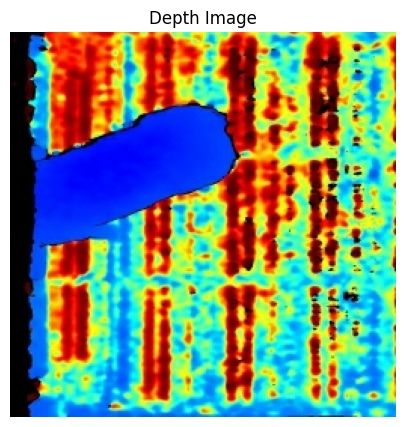

In [24]:
def visualize_sample(dataset):
    for img_batch, label_batch in dataset.take(1):
        img = img_batch[0].numpy().squeeze()

        plt.figure(figsize=(10, 5))
        plt.imshow(img, cmap='gray')
        plt.title('Depth Image')
        plt.axis('off')

        plt.show()

visualize_sample(train_dataset)

In [25]:
!nvidia-smi

Thu May  4 16:34:24 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P0    27W /  70W |    439MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [26]:
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.regularizers import l2

base_model = Xception(input_shape=(256, 256, 3), include_top=False, weights='imagenet')
x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu', kernel_regularizer=l2(0.01))(x)
x = Dropout(0.3)(x)
x = Dense(1, activation='linear')(x)
model = tf.keras.models.Model(inputs=base_model.input, outputs=x)
# Freeze pre-trained layers---------------------------------------
for layer in base_model.layers:
    layer.trainable = False
#--------------------------------------------------------------------
model.compile(optimizer='adam', loss='mse', metrics=['mae','mape'])



model.summary()
history = model.fit(train_dataset, epochs=20, validation_data=test_dataset)

83683744/83683744 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 127, 127, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 127, 127, 32  128        ['block1_conv1[0][0]']           
 ation)                      

In [27]:
# Unfreeze the last 20 layers of encoder parts
for layer in model.layers[:-20]:
    layer.trainable = False
for layer in model.layers[-20:]:
    layer.trainable = True

# smaller learning rate
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),loss='mse', metrics=['mae','mape'])
model.summary()
history_uf = model.fit(train_dataset,epochs=20,validation_data=test_dataset)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 127, 127, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 127, 127, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                                                             

In [28]:
test_loss, test_mae, test_mape = model.evaluate(test_dataset)
print('Test loss:', test_loss)
print('Test mean absolute error:', test_mae)
print('Test mean absolute percentage error:', test_mape)

146/146 [==============================] - 52s 356ms/step - loss: 15.9284 - mae: 2.6569 - mape: 10.0606
Test loss: 15.928383827209473
Test mean absolute error: 2.6568520069122314
Test mean absolute percentage error: 10.060606956481934
